In [48]:
import sys
sys.path.insert(0, "../../../code")

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
from algorithms import ChainTopology, RingTopology, QuadraticsTask, relaysum_model, relaysum_grad, relaysum_mix, all_reduce, gossip, d2, gradient_tracking, BinaryTreeTopology, relaysum_grad_overlap, StarTopology
from random_quadratics import RandomQuadraticsTask
import torch
import math
import tuning
import pandas as pd
from warehouse import Warehouse

In [51]:
torch.set_default_dtype(torch.float64)

In [52]:
star = StarTopology(32)
min(torch.eig(star.gossip_matrix()).eigenvalues[:, 0])

tensor(1.1102e-16)

# Reach a fixed plateau

In [53]:
num_workers = 32
d = 10
# noise = 0.5
noise = 0
mu = 0.5
zetas = [0, .01, .1]
max_steps = [100, 500, 1000]
eval_intervals = [2, 11, 100]
plateau = 1e-6
seed = 0

In [54]:
warehouse = Warehouse()

In [58]:
algorithm_name = "Gossip"
algorithm = gossip
topology_name = "star"
topology = StarTopology(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    print(f"Tuning for {zeta2}")
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=70000, num_test_points=1000)
    if learning_rate is None:
        continue
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

Tuning for 0
9.951348154981266e-13
Tuning for 0.01
0.008871897972707429
Tuning for 0.1
0.061518614023696905


In [59]:
algorithm_name = "D2"
algorithm = d2
topology_name = "star"
topology = StarTopology(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    eval_interval = 1
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    steps, learning_rate = tuning.tune_fastest(start_lr=10, target_quality=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=10000, num_test_points=1000)
    print(steps, learning_rate)
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

65 0.078125
4.819784528514719e-05
65 0.078125
9.018948782246738e-13
65 0.078125
9.132139489054225e-13


In [62]:
algorithm_name = "Gradient tracking"
algorithm = gradient_tracking
topology_name = "star"
topology = StarTopology(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    eval_interval = 1
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    steps, learning_rate = tuning.tune_fastest(start_lr=10, target_quality=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=10000, num_test_points=1000)
    print(steps, learning_rate)
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

9 0.72265625
4.090303903591494e-07
280 0.01781463623046875
1.386160509525558e-05
295 0.017242431640625
1.0011931839137844e-09


In [60]:
algorithm_name = "RelaySum/Model"
algorithm = relaysum_model
topology_name = "chain"
topology = StarTopology(num_workers)

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    eval_interval = 1
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_fastest(start_lr=10, target_quality=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=10000, num_test_points=1000)
    print(steps, learning_rate)
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

8 0.78125
5.198376145000512e-13
8 0.78125
5.200406077987552e-13
8 0.78125
5.204725539442734e-13


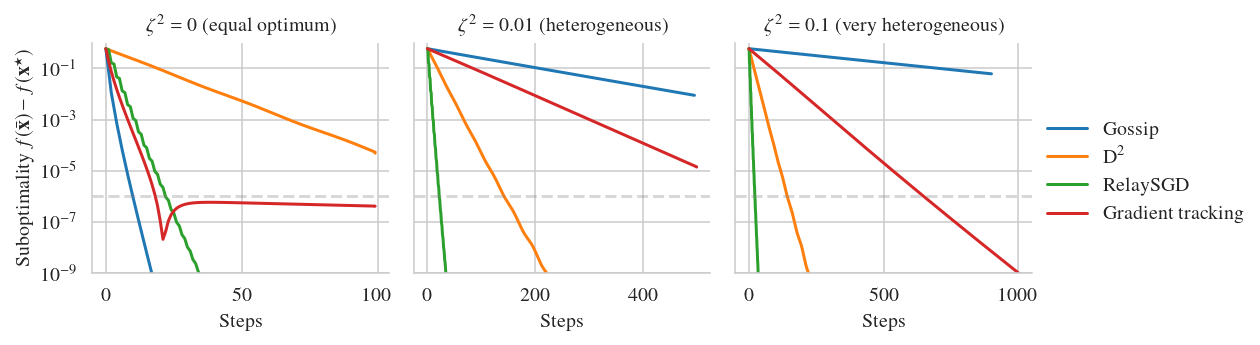

In [64]:
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'text.latex.preamble' : r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{newtxmath}'
})

df = warehouse.query("error")
df["zeta2name"] = df["zeta2"].replace({0: "0 (equal optimum)", .01: "0.01 (heterogeneous)", .1: "0.1 (very heterogeneous)"})
df["algoname"] = df.algorithm.replace({"D2": r"$\text{D}^2$", "RelaySum/Model": "RelaySGD"})
g = sns.FacetGrid(hue="algoname", col="zeta2name", data = df, height=2.5, sharex=False);
g.map(plt.plot, "step", "value")

for ax in g.axes[0]:
    ax.axhline(1e-6, ls='--', c='gray', alpha=0.3)

g.set_titles(r"$\zeta^2 =$ {col_name}")
g.set(yscale="log");
# g.set_ylabels(r"Mean sq. distance to optimum")
g.set_ylabels(r"Suboptimality $f(\bar{\mathbf{x}}) - f(\mathbf{x}^\star)$")
g.set(xlabel="Steps")
g.tight_layout()
g.set(ylim=[1e-9, 1])
g.add_legend(title="");

In [65]:
g.savefig("effect_of_heterogeneity_fixed_saturation_star.pdf", bbox_inches="tight")

# Trash bin

In [45]:
algorithm_name = "RelaySum/Grad"
algorithm = relaysum_grad
topology_name = "chain"
topology = StarTopology(num_workers)
seed = 3

warehouse.clear("error", {"algorithm": algorithm_name})

for zeta2, eval_interval, num_steps in zip(zetas, eval_intervals, max_steps):
    task = RandomQuadraticsTask(num_workers, d=d, heterogeneity=zeta2, sgd_noise=noise, mu=mu, seed=seed)
    steps, learning_rate = tuning.tune_plateau(start_lr=10, desired_plateau=plateau, task=task, algorithm=algorithm, topology=topology, max_steps=10000, num_test_points=1000)
    print(steps, learning_rate)
    tags = {"algorithm": algorithm_name, "learning_rate": learning_rate, "zeta2": zeta2}
    warehouse.clear("error", tags)
    errors = {}
    for iterate in algorithm(task, topology, learning_rate, num_steps):
        if iterate.step % eval_interval == 0:
            error = task.error(iterate.state).item() #/ initial_error
            errors[iterate.step] = error
#             if error - errors.get(iterate.step - eval_interval * 10, 1000000) > -1e-6:
#                 print("no improvement after", iterate.step)
#                 break
            if error < 1e-12:
                break
            warehouse.log_metric(
                "error", {"value": error, "step": iterate.step}, tags
            )
    print(error)

17 0.60546875
4.4001555867632207e-14
17 0.5859375
7.90776377712632e-09
17 0.5859375
7.908125415623246e-08
